In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv("Consumo_cerveja.txt", header=0, delimiter=',', decimal=".", names=["DATA","TEMPMED","TEMPMIN","TEMPMAX","PREC","FINSEM","CONSUM"])

In [11]:
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATA     365 non-null    object 
 1   TEMPMED  365 non-null    float64
 2   TEMPMIN  365 non-null    float64
 3   TEMPMAX  365 non-null    float64
 4   PREC     365 non-null    float64
 5   FINSEM   365 non-null    int64  
 6   CONSUM   365 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 20.1+ KB


,TEMPMED,TEMPMIN,TEMPMAX,PREC,FINSEM,CONSUM
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,0.284932,25401.367123
std,3.180108,2.826185,4.317366,12.417844,0.452001,4399.142703
min,12.900000,10.600000,14.500000,0.000000,0.000000,14343.000000
25%,19.020000,15.300000,23.800000,0.000000,0.000000,22008.000000
50%,21.380000,17.900000,26.900000,0.000000,0.000000,24867.000000
75%,23.280000,19.600000,29.400000,3.200000,1.000000,28631.000000
max,28.860000,24.500000,36.500000,94.800000,1.000000,37937.000000


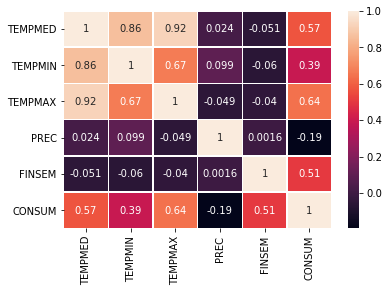

In [12]:
co = dataset.corr()
plt.figure()

ax = sns.heatmap(co, annot=True, linewidths=.5)

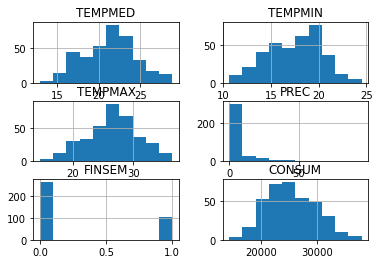

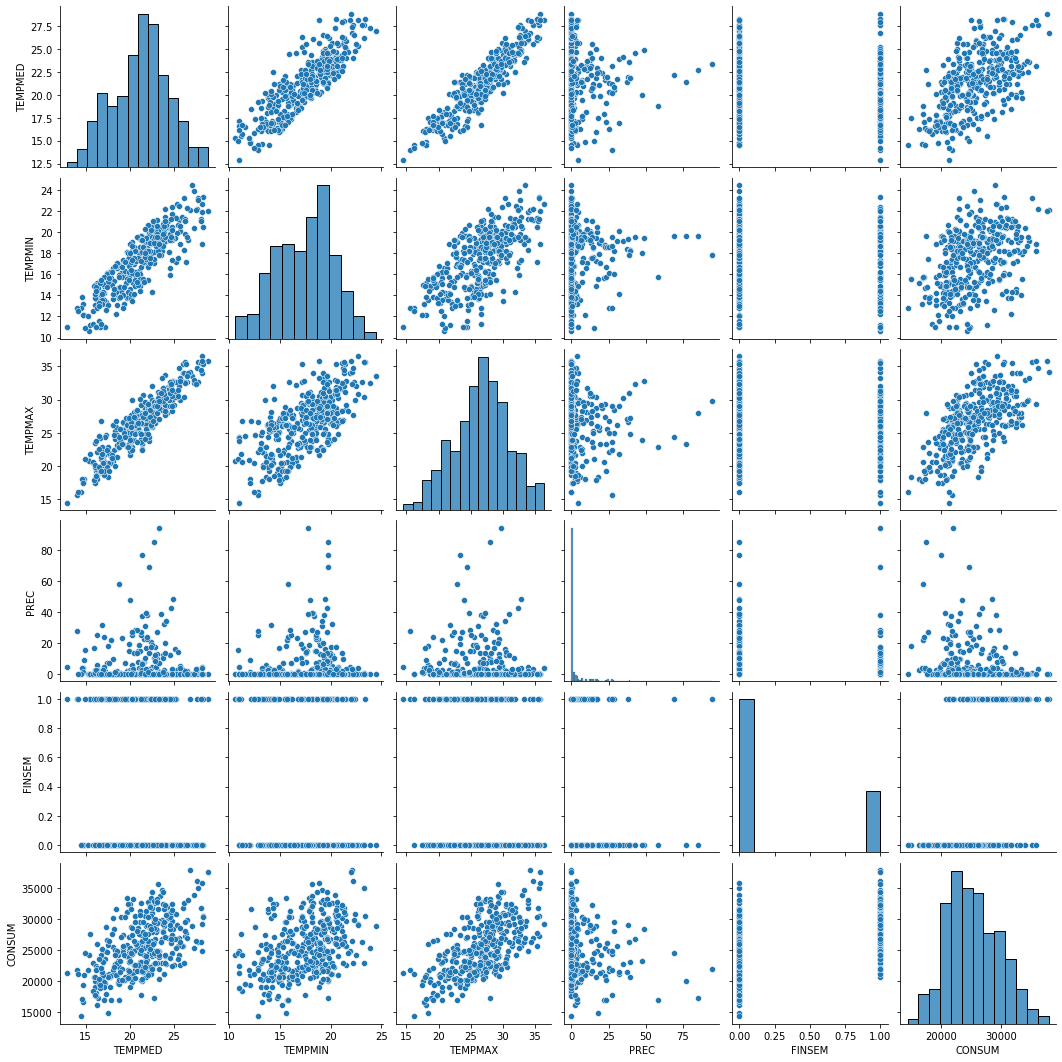

In [17]:
dataset.hist()
rel = sns.pairplot(dataset)

In [16]:
dataset.drop(['PREC'], axis=1)

,DATA,TEMPMED,TEMPMIN,TEMPMAX,FINSEM,CONSUM
0,2015-01-01,27.30,23.9,32.5,0,25461
1,2015-01-02,27.02,24.5,33.5,0,28972
2,2015-01-03,24.82,22.4,29.9,1,30814
3,2015-01-04,23.98,21.5,28.6,1,29799
4,2015-01-05,23.82,21.0,28.3,0,28900
...,...,...,...,...,...,...
360,2015-12-27,24.00,21.1,28.2,1,32307
361,2015-12-28,22.64,21.1,26.7,0,26095
362,2015-12-29,21.68,20.3,24.1,0,22309
363,2015-12-30,21.38,19.3,22.4,0,20467
